In [9]:
import os
import copy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [10]:
import parsing
import helper

In [11]:
def is_trivial_filter(trivial_instances):
    return lambda row: not (row['network'],row['spec'],row['mirror']) in trivial_instances

# Epsilon Equivalence

## Loading ACAS

In [12]:
# Load trivial_acas.pkl
trivial_acas = pickle.load(open('trivial_acas.pkl', 'rb'))

In [13]:
results_full_acas = pd.concat([
    parsing.parse_log_dirs(
    [(f"../experiments_final/acas-0.05/VeryDiff-OneThread-{p}-Naive", f"prune-{p}") for p in [5, 10, 30]],
    "VeryDiff-Naive", "0.05", parsing.parse_verydiff),
    parsing.parse_log_dirs(
    [(f"../experiments_final/acas-0.05/VeryDiff-OneThread-{p}-Combined", f"prune-{p}") for p in [5, 10, 30]],
    "VeryDiff-Combined", "0.05", parsing.parse_verydiff)
])
# Filter out trivial instances
results_full_acas = results_full_acas[results_full_acas.apply(is_trivial_filter(trivial_acas), axis=1)]
print("Number of NNs for ACAS-Full:")
print(len(results_full_acas.groupby(['network']).size()))
print("Number of Properties for ACAS-Full:")
print(len(results_full_acas.groupby(['network', 'spec', 'mirror']).size()))

Number of NNs for ACAS-Full:
45
Number of Properties for ACAS-Full:
306


In [14]:
results_full_acas = helper.compute_speedup(results_full_acas, "VeryDiff-Combined", "VeryDiff-Naive")

Baseline:  301
Variant:  303
Merged:  301


## Loading MNIST (VeriPrune)

In [15]:
# Load trivial_mnist.pkl
trivial_mnist = pickle.load(open('trivial_mnist.pkl', 'rb'))

In [16]:
results_mnist_veriprune = pd.concat([
    parsing.parse_log_dirs(
    [(f"../experiments_final/mnist-1.0/VeryDiff-OneThread-{p}-Combined", f"prune-{p}") for p in [5]],
    "VeryDiff-Combined", "1.0", parsing.parse_verydiff),
    parsing.parse_log_dirs(
    [(f"../experiments_final/mnist-1.0/VeryDiff-OneThread-{p}-Naive", f"prune-{p}") for p in [5]],
    "VeryDiff-Naive", "1.0", parsing.parse_verydiff)
])
results_mnist_veriprune = results_mnist_veriprune[results_mnist_veriprune.apply(is_trivial_filter(trivial_acas), axis=1)]
print("Number of NNs:")
print(len(results_mnist_veriprune.groupby(['network']).size()))
print("Number of Queries:")
print(len(results_mnist_veriprune.groupby(['network', 'spec', 'mirror']).size()))

Number of NNs:
3
Number of Queries:
2400


In [17]:
results_mnist_veriprune = helper.compute_speedup(results_mnist_veriprune, "VeryDiff-Combined", "VeryDiff-Naive")

Baseline:  1743
Variant:  2113
Merged:  1743


## Loading MNIST (Ours)

In [18]:
networks = ["2_512_0.79","3_100_0.49","3_100_0.79","4_1024_0.79"]
results_mnist_own = pd.concat([
    parsing.parse_log_dirs(
    [(f"../experiments_final/mnist-1.0/VeryDiff-OneThread-{p}-Combined", f"prune-{p}") for p in networks],
    "VeryDiff-Combined", "top1", parsing.parse_verydiff),
    parsing.parse_log_dirs(
    [(f"../experiments_final/mnist-1.0/VeryDiff-OneThread-{p}-Naive", f"prune-{p}") for p in networks],
    "VeryDiff-Naive", "top1", parsing.parse_verydiff)
])
print("Number of NNs:")
print(len(results_mnist_own.groupby(['network', "mirror"]).size()))
print("Number of Queries:")
print(len(results_mnist_own.groupby(['network', 'spec', 'mirror']).size()))

Number of NNs:
4
Number of Queries:
3200


In [19]:
results_mnist_own = helper.compute_speedup(results_mnist_own, "VeryDiff-Combined", "VeryDiff-Naive")

Baseline:  260
Variant:  794
Merged:  247


## Table

In [20]:
results_full_acas["family"] = "ACAS"
results_mnist_veriprune["family"] = "MNIST (VeriPrune)"
results_mnist_own["family"] = "MNIST (Ours)"
results_epsilon = pd.concat([results_full_acas, results_mnist_veriprune, results_mnist_own])
results_epsilon["property"] = "epsilon"

results_epsilon["equivalent"] = results_epsilon["status"] == "safe"
results_epsilon["not_equivalent"] = results_epsilon["status"] == "unsafe"
results_epsilon["unknown"] = ~(results_epsilon["equivalent"] | results_epsilon["not_equivalent"])

table_epsilon = results_epsilon.groupby(["property","family", "solver"]).agg({
    "equivalent": "sum",
    "not_equivalent": "sum",
    "unknown": "sum",
    "speedup": ["median","max"]
})
table_epsilon


equivalent not_equivalent  \
                                                    sum            sum   
property family            solver                                        
epsilon  ACAS              VeryDiff-Combined        150            153   
                           VeryDiff-Naive           149            152   
         MNIST (Ours)      VeryDiff-Combined        484            310   
                           VeryDiff-Naive           106            154   
         MNIST (VeriPrune) VeryDiff-Combined        352           1761   
                           VeryDiff-Naive            23           1720   

                                             unknown   speedup               
                                                 sum    median          max  
property family            solver                                            
epsilon  ACAS              VeryDiff-Combined       3       NaN          NaN  
                           VeryDiff-Naive          5  0.777266    33.599059  
         MNIST (Ours)      VeryDiff-Combined    2406       NaN          NaN  
                           VeryDiff-Naive       2940  5.093143  3326.384845  
         MNIST (VeriPrune) VeryDiff-Combined     287       NaN          NaN  
                           VeryDiff-Naive        657  0.847011  3008.330936

In [21]:
mnist_epsilon = pd.concat([results_mnist_veriprune, results_mnist_own])
mnist_epsilon["radius"] = mnist_epsilon["spec"].apply(lambda x: int(x.split("_")[-1]))
mnist_epsilon["prop_type"] = mnist_epsilon["radius"].apply(lambda x: "local" if x > 6 else "global")

In [22]:
font = {'size'   : 20}

plt.rc('font', **font)

/tmp/ipykernel_1782771/2588363583.py:12: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for label, solver_instances in mnist_epsilon[mnist_epsilon["prop_type"] == "global"].groupby(["solver"]):
/tmp/ipykernel_1782771/2588363583.py:22: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for label, solver_instances in mnist_epsilon[mnist_epsilon["prop_type"] == "local"].groupby(["solver"]):


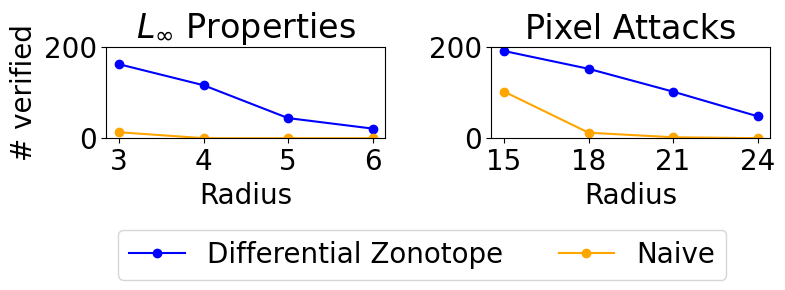

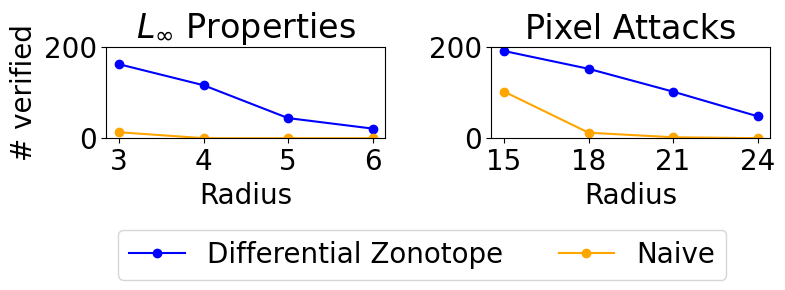

In [24]:
labels = {
    ("VeryDiff-Combined",): "Differential Zonotope",
    ("VeryDiff-Naive",): "Naive"
}
colors = {
    ("VeryDiff-Combined",): "blue",
    ("VeryDiff-Naive",): "orange"
}
mnist_epsilon["solved"] = (mnist_epsilon["status"] == "safe" ) #| (mnist_epsilon["status"] == "unsafe")
fig, ax = plt.subplots(1, 2, figsize=(8, 2))
fig.tight_layout()
for label, solver_instances in mnist_epsilon[mnist_epsilon["prop_type"] == "global"].groupby(["solver"]):
    res = solver_instances.groupby(["radius"]).agg({
        "solved": "sum"
    })
    ax[0].plot(res.index, res["solved"], label=labels[label], marker="o", color=colors[label])
ax[0].set_title("$L_\infty$ Properties")
ax[0].set_xlabel("Radius")
ax[0].set_ylabel("# verified")
ax[0].set_xticks(range(3, 7))
ax[0].set_ylim(0,200)
for label, solver_instances in mnist_epsilon[mnist_epsilon["prop_type"] == "local"].groupby(["solver"]):
    res = solver_instances.groupby(["radius"]).agg({
        "solved": "sum"
    })
    ax[1].plot(res.index, res["solved"], marker="o", color=colors[label])
ax[1].set_title("Pixel Attacks")
ax[1].set_xlabel("Radius")
ax[1].set_xticks([15,18,21,24])
ax[1].set_ylim(0,200)
fig.legend(loc='upper center',bbox_to_anchor=(0.5, -0.05),ncol=2)
fig


In [25]:
fig.savefig("abelation_mnist_epsilon.eps", bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [17]:
mnist_epsilon[mnist_epsilon["prop_type"] == "global"].groupby(["solver","radius"]).agg({
    "solved": "sum"
})

solved
solver            radius        
VeryDiff-Combined 3          162
                  4          116
                  5           44
                  6           21
VeryDiff-Naive    3           13
                  4            0
                  5            0
                  6            0

# Top-1 Equivalence

## Loading MNIST (VeriPrune)

In [18]:
trivial_top1 = pickle.load(open('trivial_top1_mnist.pkl', 'rb'))

In [19]:
results_top1_mnist_veriprune = pd.concat([
    parsing.parse_log_dirs(
    [(f"../experiments_final/mnist-top1/VeryDiff-OneThread-{p}-Combined", f"prune-{p}") for p in [5]],
    "VeryDiff-Combined", "top1", parsing.parse_verydiff),
    parsing.parse_log_dirs(
    [(f"../experiments_final/mnist-top1/VeryDiff-OneThread-{p}-Naive", f"prune-{p}") for p in [5]],
    "VeryDiff-Naive", "top1", parsing.parse_verydiff)
])
results_top1_mnist_veriprune = results_top1_mnist_veriprune[results_top1_mnist_veriprune["network"]!="mnist_relu_4_1024"]
results_top1_mnist_veriprune = results_top1_mnist_veriprune[results_top1_mnist_veriprune.apply(is_trivial_filter(trivial_top1), axis=1)].copy()
print("Number of NNs:")
print(len(results_top1_mnist_veriprune.groupby(['network']).size()))
print("Number of Properties:")
print(len(results_top1_mnist_veriprune.groupby(['network', 'spec', 'mirror']).size()))

Number of NNs:
2
Number of Properties:
1199


In [20]:
results_top1_mnist_veriprune = helper.compute_speedup(results_top1_mnist_veriprune, "VeryDiff-Combined", "VeryDiff-Naive")

Baseline:  969
Variant:  938
Merged:  938


## Loading MNIST (Ours)

In [21]:
networks = ["2_512_0.79","3_100_0.49","3_100_0.79","4_1024_0.79"]
results_top1_mnist_ours = pd.concat([
    parsing.parse_log_dirs(
    [(f"../experiments_final/mnist-top1/VeryDiff-OneThread-{p}-Combined", f"prune-{p}") for p in networks],
    "VeryDiff-Combined", "top1", parsing.parse_verydiff),
    parsing.parse_log_dirs(
    [(f"../experiments_final/mnist-top1/VeryDiff-OneThread-{p}-Naive", f"prune-{p}") for p in networks],
    "VeryDiff-Naive", "top1", parsing.parse_verydiff)
])
print("Number of NNs:")
print(len(results_top1_mnist_ours.groupby(['network',"mirror"]).size()))
print("Number of Properties:")
print(len(results_top1_mnist_ours.groupby(['network', 'spec', 'mirror']).size()))

Number of NNs:
4
Number of Properties:
2400


In [22]:
results_top1_mnist_ours = helper.compute_speedup(results_top1_mnist_ours, "VeryDiff-Combined", "VeryDiff-Naive")

Baseline:  1585
Variant:  1532
Merged:  1531


## Table

In [23]:
results_top1_mnist_veriprune["family"] = "MNIST (VeriPrune)"
results_top1_mnist_ours["family"] = "MNIST (Ours)"
results_top1 = pd.concat([ results_top1_mnist_veriprune, results_top1_mnist_ours])
results_top1["property"] = "Top-1"

results_top1["equivalent"] = results_top1["status"] == "safe"
results_top1["not_equivalent"] = results_top1["status"] == "unsafe"
results_top1["unknown"] = ~(results_top1["equivalent"] | results_top1["not_equivalent"])

results_top1.groupby(["property","family", "solver"]).agg({
    "equivalent": "sum",
    "not_equivalent": "sum",
    "unknown": "sum",
    "speedup": ["median","max"]
})


equivalent not_equivalent  \
                                                    sum            sum   
property family            solver                                        
Top-1    MNIST (Ours)      VeryDiff-Combined       1401            131   
                           VeryDiff-Naive          1433            152   
         MNIST (VeriPrune) VeryDiff-Combined        885             53   
                           VeryDiff-Naive           895             74   

                                             unknown   speedup             
                                                 sum    median        max  
property family            solver                                          
Top-1    MNIST (Ours)      VeryDiff-Combined     868       NaN        NaN  
                           VeryDiff-Naive        815  0.767789   4.180738  
         MNIST (VeriPrune) VeryDiff-Combined     261       NaN        NaN  
                           VeryDiff-Naive        230  0.772264  17.406125

# Full Table

In [24]:
pd.concat([results_epsilon, results_top1]).groupby(["property","family", "solver"]).agg({
    "equivalent": "sum",
    "not_equivalent": "sum",
    "unknown": "sum",
    "speedup": ["median","max"]
})

equivalent not_equivalent  \
                                                    sum            sum   
property family            solver                                        
Top-1    MNIST (Ours)      VeryDiff-Combined       1401            131   
                           VeryDiff-Naive          1433            152   
         MNIST (VeriPrune) VeryDiff-Combined        885             53   
                           VeryDiff-Naive           895             74   
epsilon  ACAS              VeryDiff-Combined        150            153   
                           VeryDiff-Naive           149            152   
         MNIST (Ours)      VeryDiff-Combined        484            310   
                           VeryDiff-Naive           106            154   
         MNIST (VeriPrune) VeryDiff-Combined        352           1761   
                           VeryDiff-Naive            23           1720   

                                             unknown   speedup               
                                                 sum    median          max  
property family            solver                                            
Top-1    MNIST (Ours)      VeryDiff-Combined     868       NaN          NaN  
                           VeryDiff-Naive        815  0.767789     4.180738  
         MNIST (VeriPrune) VeryDiff-Combined     261       NaN          NaN  
                           VeryDiff-Naive        230  0.772264    17.406125  
epsilon  ACAS              VeryDiff-Combined       3       NaN          NaN  
                           VeryDiff-Naive          5  0.777266    33.599059  
         MNIST (Ours)      VeryDiff-Combined    2406       NaN          NaN  
                           VeryDiff-Naive       2940  5.093143  3326.384845  
         MNIST (VeriPrune) VeryDiff-Combined     287       NaN          NaN  
                           VeryDiff-Naive        657  0.847011  3008.330936

In [25]:
print(pd.concat([results_epsilon, results_top1]).groupby(["property","family", "solver"]).agg({
    "equivalent": "sum",
    "not_equivalent": "sum",
    "unknown": "sum",
    "speedup": ["median","max"]
}).to_latex())

\begin{tabular}{lllrrrrr}
\toprule
        &                   &                & equivalent & not\_equivalent & unknown & \multicolumn{2}{l}{speedup} \\
        &                   &                &        sum &            sum &     sum &    median &          max \\
property & family & solver &            &                &         &           &              \\
\midrule
Top-1 & MNIST (Ours) & VeryDiff-Combined &       1401 &            131 &     868 &       NaN &          NaN \\
        &                   & VeryDiff-Naive &       1433 &            152 &     815 &  0.767789 &     4.180738 \\
        & MNIST (VeriPrune) & VeryDiff-Combined &        885 &             53 &     261 &       NaN &          NaN \\
        &                   & VeryDiff-Naive &        895 &             74 &     230 &  0.772264 &    17.406125 \\
epsilon & ACAS & VeryDiff-Combined &        150 &            153 &       3 &       NaN &          NaN \\
        &                   & VeryDiff-Naive &        149 &  

/tmp/ipykernel_465237/1215718436.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pd.concat([results_epsilon, results_top1]).groupby(["property","family", "solver"]).agg({
